In [1]:
with open("pg8774.txt","r") as f:
    raw_text = f.read()

In [3]:
raw_text[:300]

'\ufeffThe Project Gutenberg eBook of Poems in Two Volumes, Volume 1\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gut'

In [4]:
len(raw_text)

108558

In [6]:
import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)',raw_text)

In [8]:
preprocessed[:10]

['\ufeffThe', ' ', 'Project', ' ', 'Gutenberg', ' ', 'eBook', ' ', 'of', ' ']

In [9]:
len(preprocessed)

61171

In [13]:
tokens = list(set(preprocessed))

In [18]:
tokens = sorted(tokens)

In [20]:
for i in enumerate(tokens):
    print(i)

(0, '')
(1, '\n')
(2, ' ')
(3, '!')
(4, '"')
(5, '#8774]')
(6, '$1')
(7, '$5')
(8, '&')
(9, '&c')
(10, "'")
(11, '(')
(12, ')')
(13, '*')
(14, '***')
(15, ',')
(16, '-')
(17, '--')
(18, '.')
(19, '000')
(20, '1')
(21, '10')
(22, '100')
(23, '11')
(24, '110')
(25, '112')
(26, '12')
(27, '120')
(28, '13')
(29, '130')
(30, '14')
(31, '140')
(32, '15')
(33, '150')
(34, '1500')
(35, '152')
(36, '158')
(37, '15th')
(38, '16')
(39, '160')
(40, '17')
(41, '18')
(42, '1802')
(43, '1803')
(44, '19')
(45, '1st')
(46, '2')
(47, '20')
(48, '20%')
(49, '2001')
(50, '2005')
(51, '2021')
(52, '21')
(53, '22')
(54, '23')
(55, '24')
(56, '25')
(57, '26')
(58, '3')
(59, '30')
(60, '35')
(61, '37')
(62, '4')
(63, '40')
(64, '43')
(65, '45')
(66, '5')
(67, '50')
(68, '501')
(69, '58')
(70, '596-1887')
(71, '6')
(72, '60')
(73, '63')
(74, '64')
(75, '64-6221541')
(76, '7')
(77, '70')
(78, '71')
(79, '7th')
(80, '8')
(81, '80')
(82, '801')
(83, '809')
(84, '84116')
(85, '9')
(86, '90')
(87, ':')
(88, ';')
(8

In [21]:
vocab = {token:integer for integer,token in  enumerate(tokens)}

In [27]:
vocab['beautiful']

1593

In [42]:
sample_txt = "Nature is beautiful"

In [43]:
class SimpleTokenizerV1:
    
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [44]:
tokenizer = SimpleTokenizerV1(vocab)

In [45]:
tokenizer.decode(tokenizer.encode(sample_txt))

'Nature is beautiful'

In [50]:
from supplementary import create_dataloader_v1


dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[  171,   119,   123,   464],
        [ 4935, 20336, 46566,   286],
        [ 7695,  5232,   287,  4930],
        [ 4709,  8139,    11, 14701],
        [  352,   198,   220,   220],
        [  220,   220,   198,  1212],
        [47179,   318,   329,   262],
        [  779,   286,  2687,  6609]])

Targets:
 tensor([[  119,   123,   464,  4935],
        [20336, 46566,   286,  7695],
        [ 5232,   287,  4930,  4709],
        [ 8139,    11, 14701,   352],
        [  198,   220,   220,   220],
        [  220,   198,  1212, 47179],
        [  318,   329,   262,   779],
        [  286,  2687,  6609,   287]])


## LLM Arch.

In [51]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [53]:
import torch.nn as nn
from blocks import TransformerBlock, LayerNorm


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [54]:
import torch
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [55]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 6.4165e-02,  2.0443e-01, -1.6945e-01,  ...,  1.7887e-01,
           2.1921e-01, -5.8153e-01],
         [ 3.7736e-01, -4.2545e-01, -6.5874e-01,  ..., -2.5050e-01,
           4.6553e-01, -2.5760e-01],
         [ 8.8996e-01, -1.3770e-01,  1.4748e-01,  ...,  1.7770e-01,
          -1.2015e-01, -1.8902e-01],
         [-9.7276e-01,  9.7338e-02, -2.5419e-01,  ...,  1.1035e+00,
           3.7639e-01, -5.9006e-01]],

        [[ 6.4165e-02,  2.0443e-01, -1.6945e-01,  ...,  1.7887e-01,
           2.1921e-01, -5.8153e-01],
         [ 1.3433e-01, -2.1289e-01, -2.7020e-02,  ...,  8.1153e-01,
          -4.7410e-02,  3.1186e-01],
         [ 8.9996e-01,  9.5396e-01, -1.7896e-01,  ...,  8.3053e-01,
           2.7657e-01, -2.4577e-02],
         [-9.3264e-05,  1.9390e-01,  5.1217e-01,  ...,  1.1915e+00,
          -1.6431e-01,  3.7046e-02]]], grad_fn=<UnsafeViewBackward0>)


In [56]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [58]:
model.eval();  # disable dropout

In [59]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [60]:
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [61]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


In [62]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.2
numpy version: 1.24.4
tiktoken version: 0.7.0
torch version: 2.4.0


In [66]:
import torch
from gpt import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [69]:
from supplementary import create_dataloader_v1

text_data = raw_text
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [74]:
from gpt import calc_loss_loader


device = torch.device("mps")
model.to(device)


torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.03698344149832
Validation loss: 10.990407562255859


In [76]:
from gpt import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [77]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.322, Val loss 9.739
Ep 1 (Step 000005): Train loss 7.592, Val loss 8.461
Ep 1 (Step 000010): Train loss 6.314, Val loss 7.911
Ep 1 (Step 000015): Train loss 5.870, Val loss 7.771
Ep 1 (Step 000020): Train loss 5.919, Val loss 7.901
Ep 1 (Step 000025): Train loss 5.464, Val loss 7.797
Ep 1 (Step 000030): Train loss 5.799, Val loss 7.783
Ep 1 (Step 000035): Train loss 5.420, Val loss 7.741
Ep 1 (Step 000040): Train loss 5.540, Val loss 7.667
Ep 1 (Step 000045): Train loss 5.415, Val loss 7.570
Ep 1 (Step 000050): Train loss 5.495, Val loss 7.557
Ep 1 (Step 000055): Train loss 5.476, Val loss 7.573
Every effort moves you,                                                 
Ep 2 (Step 000060): Train loss 5.061, Val loss 7.589
Ep 2 (Step 000065): Train loss 5.399, Val loss 7.612
Ep 2 (Step 000070): Train loss 5.138, Val loss 7.778
Ep 2 (Step 000075): Train loss 4.626, Val loss 7.852
Ep 2 (Step 000080): Train loss 4.828, Val loss 7.862
Ep 2 (Step 000085): Train 

In [78]:
torch.save(model.state_dict(), "model.pth")

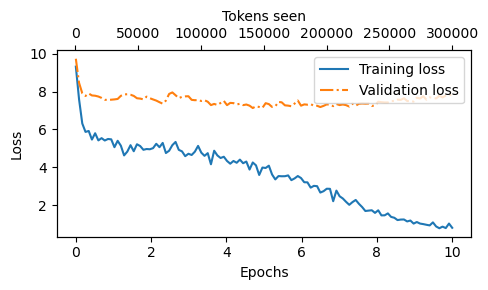

In [80]:
from gpt import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [83]:
import tiktoken
from gpt import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [88]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("mps")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=100,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you, with her all, when the while, 1802.



1.



















on which the phrase “Project Gutenberg” appears, or with which the













1.







NOTE VII.













paragraph 1.C.


In [105]:
import torch
import tiktoken
from gpt import generate_text_simple

def generate_recursively(text, tokenizer, model, max_tokens=50, device='mps'):
    
    model = model.to(device)
    
    token_ids = text_to_token_ids(text, tokenizer).to(device)
    
    generated_text = text
    for _ in range(max_tokens):
       
        with torch.no_grad():
            output = model(token_ids)
        
        next_token_id = torch.argmax(output[:, -1, :], dim=-1).item()
        next_token = tokenizer.decode([next_token_id])

        if next_token == '\n\n' or next_token == '     ':
            continue
        
        generated_text += next_token

        token_ids = text_to_token_ids(generated_text, tokenizer).to(device)

    return generated_text

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) 
    return tokenizer.decode(flat.tolist())

In [106]:
(generate_recursively("Every effort moves you", tokenizer, model, max_tokens=100))

'Every effort moves you,\n                                                                                                  '